# Bonus: Temperature Analysis I

In [5]:
import pandas as pd
from datetime import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt

In [6]:
# "tobs" is "temperature observations"
df = pd.read_csv('Resources/hawaii_measurements.csv')
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


### Compare June and December data across all years 

In [7]:
from scipy import stats
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station
session = Session(bind=engine)

In [11]:
# Filter data for desired months
June = session.query(Measurement.date, Measurement.tobs)\
    .filter(func.extract("month", Measurement.date) == "6").all()
# June

December = session.query(Measurement.date, Measurement.tobs)\
    .filter(func.extract("month", Measurement.date) == "12").all()
# December

June_df = pd.DataFrame(June, columns = ["Date", "Temperature"])
December_df = pd.DataFrame(December, columns = ["Date", "Temperature"])
June_df.head()

,Date,Temperature
0,2010-06-01,78.0
1,2010-06-02,76.0
2,2010-06-03,78.0
3,2010-06-04,76.0
4,2010-06-05,77.0


In [12]:
# Identify the average temperature for June
avg_June = June_df["Temperature"].mean()
avg_June

74.94411764705882

In [13]:
# Identify the average temperature for December
avg_December = December_df["Temperature"].mean()
avg_December

71.04152933421226

In [14]:
# Create collections of temperature data
temp_June = June_df["Temperature"]
# temp_June

temp_December = December_df["Temperature"]
# temp_June

In [15]:
# Run paired t-test
result = stats.ttest_ind(temp_June, temp_December)
result

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Analysis

### With a p-value much smaller than threshold  = 0.05, we can conclude that the difference of Tempearture between June and December is significant (t = 31.60; p = 3.90e-191).

## Bonus Challenge Assignment: Temperature Analysis II

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_temp = calc_temps('2017-08-01', '2017-08-07')
trip_temp[0]

(72.0, 79.25, 83.0)

In [18]:
trip_temp_dict = {"Min": [72.0],"Avg":[79.25],"Max":[83.0]}
# trip_temp_dict
temp_df = pd.DataFrame.from_dict(trip_temp_dict, orient="index", columns=["Temp"])
temp_df

,Temp
Min,72.00
Avg,79.25
Max,83.00


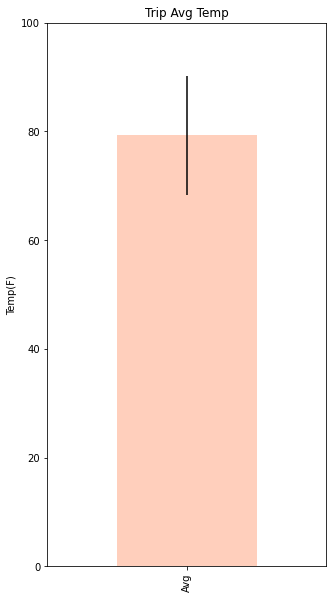

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = trip_temp[0][2]-trip_temp[0][0]
error
temp_df[1:2].plot(kind="bar", figsize=(5,10), ylim=(0,100), color="lightsalmon", alpha=0.5, legend=False, yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.savefig("Images/Temperature.png")
plt.show()

### Daily Rainfall Average

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prcp = session.query(Measurement.station, func.round(func.sum(Measurement.prcp), 2))\
    .filter(Measurement.date > '2017-08-01')\
    .filter(Measurement.date <= '2017-08-07')\
    .order_by(Measurement.date).group_by(Measurement.station).all()

prcp

[('USC00514830', 0.1),
 ('USC00516128', 0.36),
 ('USC00519397', 0.02),
 ('USC00519523', 0.0),
 ('USC00519281', 0.06)]

### Daily Temperature Normals

In [21]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dates = ["08-01", "08-02", "08-03", "08-04", "08-05", "08-06", "08-07"]

# use daily normals function to calculate temp for each date in trip_dates and append to list

results = []

for i, date in enumerate(dates):
    
    trip_temps = daily_normals(date)
    
    results.append(trip_temps[0])
    
print(results)



[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temps_dict = {dates[i]: results[i] for i in range(len(results))}

trip_temps_dict


{'08-01': (67.0, 75.54, 83.0),
 '08-02': (68.0, 75.60377358490567, 84.0),
 '08-03': (70.0, 76.61111111111111, 85.0),
 '08-04': (69.0, 76.71153846153847, 84.0),
 '08-05': (69.0, 76.14814814814815, 82.0),
 '08-06': (67.0, 76.25, 83.0),
 '08-07': (71.0, 77.15686274509804, 83.0)}

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df = pd.DataFrame.from_dict(trip_temps_dict, orient="index", columns=["tMin", "tAvg", "tMax"])
trip_df

,tMin,tAvg,tMax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


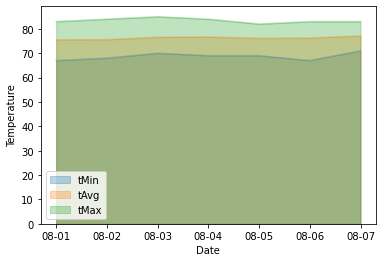

In [25]:
trip_df.plot.area(stacked=False, alpha=0.3)
plt.ylabel("Temperature")
plt.xlabel("Date")
plt.savefig("Images/daily-normals.png")
plt.show()

In [26]:
session.close()